In [1]:
import os
import numpy as np
import scipy.io
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set the directory path and file names
data_dir = "/home/saher/Documents/data_preprocessed_matlab"
file_names = [f"s{i:02d}.mat" for i in range(1, 33)]  # s01.mat to s32.mat

# Initialize lists to hold data and labels
X_data = []
y_clip = []

# Load and preprocess the data
for participant_id, file_name in enumerate(file_names, start=1):
    file_path = os.path.join(data_dir, file_name)
    mat = scipy.io.loadmat(file_path)
    
    eeg_data = mat['data']  # shape: (40, 32, 8064)
    
    # Loop over each clip (40 clips per participant)
    for clip_id in range(40):
        clip_data = eeg_data[clip_id, :32, 384:]  # Skip first 3 seconds (3*128=384)
        
        # Loop over each second in the clip (60 seconds per clip)
        for second in range(60):
            start_idx = second * 128
            end_idx = (second + 1) * 128
            second_data = clip_data[:, start_idx:end_idx]
            
            X_data.append(second_data)
            y_clip.append(clip_id)  # Zero-based index for labels

# Convert lists to numpy arrays
X_data = np.array(X_data)
y_clip = np.array(y_clip)

# Encode the clip labels
clip_encoder = LabelEncoder()
y_clip_encoded = clip_encoder.fit_transform(y_clip)

# Convert labels to one-hot encoding
y_clip_onehot = tf.keras.utils.to_categorical(y_clip_encoded, num_classes=len(clip_encoder.classes_))

# Scale the data
scaler = StandardScaler()
X_data = X_data.reshape(-1, 32 * 128)  # Flatten for scaling
X_data = scaler.fit_transform(X_data)
X_data = X_data.reshape(-1, 32, 128)  # Reshape back to original

2024-09-05 17:51:31.492687: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 17:51:31.493503: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 17:51:31.495867: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 17:51:31.503469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 17:51:31.517857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

In [8]:
len(clip_encoder.classes_)

40

Epoch 1/100
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0252 - loss: 3.8621 - val_accuracy: 0.0272 - val_loss: 3.7205
Epoch 2/100
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0404 - loss: 3.6870 - val_accuracy: 0.0345 - val_loss: 3.7165
Epoch 3/100
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0520 - loss: 3.6463 - val_accuracy: 0.0456 - val_loss: 3.6694
Epoch 4/100
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0664 - loss: 3.5626 - val_accuracy: 0.0584 - val_loss: 3.6000
Epoch 5/100
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0809 - loss: 3.4684 - val_accuracy: 0.0662 - val_loss: 3.5479
Epoch 6/100
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0958 - loss: 3.3761 - val_accuracy: 0.0760 - val_loss: 3.4892
Epoch 7/100
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1094 - loss: 3.3114 - val_accuracy: 0.0771 - val_loss: 3.4896
Epoch 8/100
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1172 - loss: 3

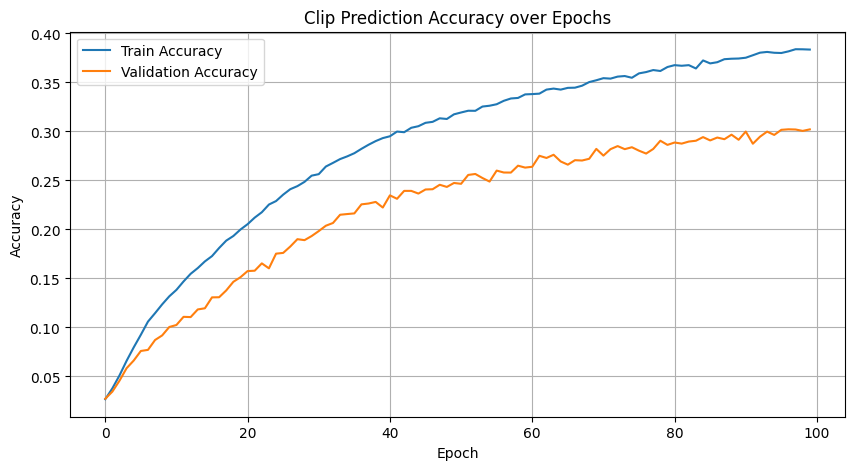

In [15]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
def create_cnn_clip_model():
    model = Sequential()    
    # Simple 1D CNN layer
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(32, 128)))
    # model.add(MaxPooling1D(pool_size=2))
    
    # Flatten and output layer
    model.add(Flatten())
    model.add(Dense(len(clip_encoder.classes_), activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate and train the model
cnn_clip_model = create_cnn_clip_model()

history = cnn_clip_model.fit(X_train, y_train, 
                             validation_data=(X_test, y_test),
                             epochs=100, batch_size=32, verbose=1)

# Evaluate the model
scores = cnn_clip_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Clip Prediction Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()